# Zadanie 4
Wykorzystaj bibliotekę NumPy do implementacji wybranych dwóch niestandardowych metod ekstrakcji cech (np. transofrmata Fouriera, analiza falowa, spektralna analiza gęstości
mocy, analiza harmoniczna, autokorelacja, metody nieliniowe), które nie są dostępne w bibliotece pandas. Przeprowadź analizę wydajnościową różnych metod ekstrakcji cech dla dużych zbiorów danych szeregów czasowych. Porównaj wydajność niestandardowych metod z
metodami dostępnymi w bibliotece pandas pod kątem czasu obliczeń.

In [1]:
import pandas as pd
import yfinance as yf
import statsmodels as sts
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
from statsmodels.tsa.stattools import acf
from statsmodels.robust import mad
from sklearn.decomposition import PCA
import numpy as np
from sklearn.decomposition import PCA

In [11]:
# Pobranie danych z yahoo finance i wstawienie do pandas dataframe
data = yf.download('SGN.WA', start='2015-01-01', end='2024-01-01')

# Nazwy kolumn tworzymy na podstawie pierwszego rekordu
data = data.reset_index()
data = data[['Date', 'Close']]
data['Date'] = pd.to_datetime(data['Date'], format='%Y-%m-%d')

# Utworzenie kompletnego zakresu dat od pierwszej do ostatniej daty w danych
complete_date_range = pd.date_range(start=data['Date'].min(), end=data['Date'].max(), freq='D')

# Utworzenie DataFrame z kompletnym zakresem dat
complete_data = pd.DataFrame({'Date': complete_date_range})

# Połączenie danych z kompletnym zakresem dat
data = pd.merge(complete_data, data, on='Date', how='left')
data['Close'] = data['Close'].interpolate(method="linear")

#data.set_index('Date', inplace=True)
data

[*********************100%%**********************]  1 of 1 completed


,Date,Close
0,2015-01-01,13.650000
1,2015-01-02,13.650000
2,2015-01-03,13.586666
3,2015-01-04,13.523333
4,2015-01-05,13.460000
...,...,...
3280,2023-12-25,42.300001
3281,2023-12-26,43.000001
3282,2023-12-27,43.700001
3283,2023-12-28,42.799999


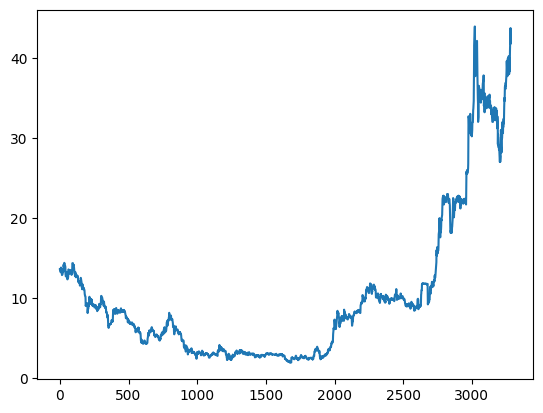

In [6]:
plt.plot(data['Close'])

Cechy z dyskretnej transformacji falkowej: [array([1.00414141e+18]), array([1.0042025e+18]), array([1.0042636e+18]), array([1.00432469e+18]), array([1.00438579e+18]), array([1.00444688e+18]), array([1.00450797e+18]), array([1.00456907e+18]), array([1.00463016e+18]), array([1.00469126e+18]), array([1.00475235e+18]), array([1.00481344e+18]), array([1.00487454e+18]), array([1.00493563e+18]), array([1.00499673e+18]), array([1.00505782e+18]), array([1.00511891e+18]), array([1.00518001e+18]), array([1.0052411e+18]), array([1.0053022e+18]), array([1.00536329e+18]), array([1.00542438e+18]), array([1.00548548e+18]), array([1.00554657e+18]), array([1.00560767e+18]), array([1.00566876e+18]), array([1.00572985e+18]), array([1.00579095e+18]), array([1.00585204e+18]), array([1.00591314e+18]), array([1.00597423e+18]), array([1.00603532e+18]), array([1.00609642e+18]), array([1.00615751e+18]), array([1.00621861e+18]), array([1.0062797e+18]), array([1.00634079e+18]), array([1.00640189e+18]), array([1.00

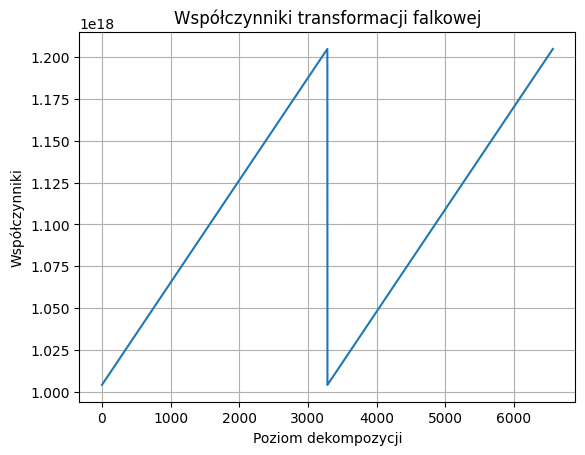

In [8]:
# Transformacj Falkowa
import pywt

ts = data
ts['Date'] = pd.to_numeric(data['Date'], errors='coerce')

def dwt_feature_extraction(data, wavelet='haar', level=1):
 coeffs = pywt.wavedec(data, wavelet, level=level)
 features = []
 for i in range(level+1):
  features.extend(coeffs[i])
 return features

dwt_features = dwt_feature_extraction(ts)
print("Cechy z dyskretnej transformacji falkowej:", dwt_features)
# Wykres współczynników DWT
plt.plot(dwt_features)
plt.title('Współczynniki transformacji falkowej')
plt.xlabel('Poziom dekompozycji')
plt.ylabel('Współczynniki')
plt.grid(True)
plt.show()


Wartości cech z analizy falkowej (cA): [[1.00414141e+18]
 [1.00420250e+18]
 [1.00426360e+18]
 ...
 [1.20465200e+18]
 [1.20471310e+18]
 [1.20477419e+18]]
Wartości cech z analizy falkowej (cD): [[1.00414141e+18]
 [1.00420250e+18]
 [1.00426360e+18]
 ...
 [1.20465200e+18]
 [1.20471310e+18]
 [1.20477419e+18]]


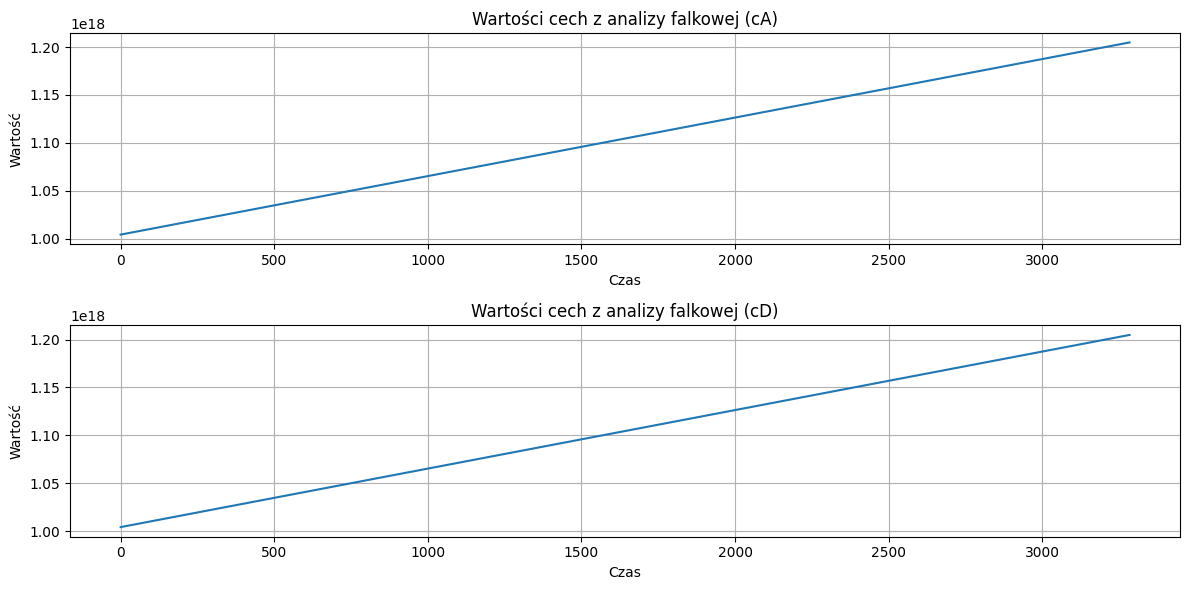

In [10]:
# Analiza falkowa
def wavelet_analysis(data, wavelet='haar'):
 cA, cD = pywt.dwt(data, wavelet)
 return cA, cD
# Ekstrakcja cech z analizy falkowej
cA, cD = wavelet_analysis(ts)
print("Wartości cech z analizy falkowej (cA):", cA)
print("Wartości cech z analizy falkowej (cD):", cD)
# Wykresy dla analizy falkowej
plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.plot(cA)
plt.title('Wartości cech z analizy falkowej (cA)')
plt.xlabel('Czas')
plt.ylabel('Wartość')
plt.grid(True)
plt.subplot(2, 1, 2)
plt.plot(cD)
plt.title('Wartości cech z analizy falkowej (cD)')
plt.xlabel('Czas')
plt.ylabel('Wartość')
plt.grid(True)
plt.tight_layout()
plt.show()


Wartości cech z autokorelacji: [1.         0.99767816 0.99509374 0.99236373 0.98970974 0.98717899
 0.98467764 0.98220276 0.97988105 0.97782902 0.97568775 0.97363888
 0.97173885 0.96982297 0.96786595 0.96585037 0.96355073 0.96127332
 0.95893521 0.95678587 0.95452473 0.95216257 0.94977597 0.94737836
 0.94505425 0.94283079 0.94076993 0.93871883 0.93665862 0.93450108
 0.93229102 0.93011416 0.92801926 0.92596757 0.92389943 0.92183693]


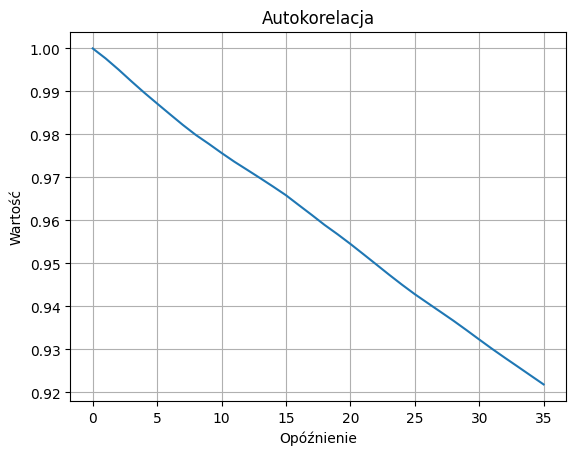

In [13]:
# AutoKorelacja
# Autokorelacja
def autocorrelation(data):
 return acf(data, fft=True)
# Ekstrakcja cech za pomocą autokorelacji
autocorr = autocorrelation(ts['Close'])
print("Wartości cech z autokorelacji:", autocorr)
# Wykres autokorelacji
plt.plot(autocorr)
plt.title('Autokorelacja')
plt.xlabel('Opóźnienie')
plt.ylabel('Wartość')
plt.grid(True)
plt.show()


Lokalne maksima (peaks): [   8   13   22   27   32   50   57   63   71   77   81   93   97   99
  112  118  126  131  137  139  144  152  161  165  174  189  193  197
  209  215  222  225  229  232  238  243  245  249  258  261  270  278
  286  292  294  301  315  321  334  340  349  357  363  369  377  384
  389  392  396  405  410  424  426  428  432  435  445  447  454  466
  468  470  482  484  491  496  505  512  517  519  525  529  531  539
  543  546  553  561  571  574  582  587  594  596  601  607  609  616
  621  629  631  635  643  645  650  652  656  669  679  684  687  693
  697  701  705  714  721  728  732  739  744  750  755  762  764  770
  782  789  796  802  809  813  818  825  827  838  844  858  861  865
  870  874  876  890  897  914  921  928  935  937  942  949  952  958
  964  968  972  974  978  988 1000 1002 1008 1012 1014 1022 1028 1036
 1043 1048 1050 1057 1063 1065 1069 1072 1077 1079 1098 1107 1112 1117
 1128 1134 1141 1152 1159 1162 1166 1168 1175 1177 1

KeyError: "None of [Index([   8,   13,   22,   27,   32,   50,   57,   63,   71,   77,\n       ...\n       3224, 3232, 3238, 3241, 3247, 3255, 3262, 3269, 3275, 3282],\n      dtype='int64', length=534)] are in the [columns]"

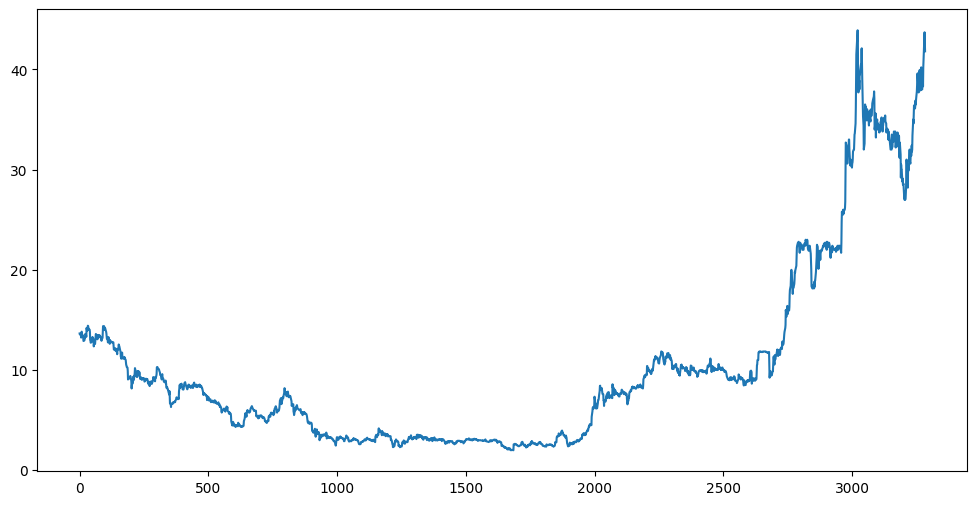

In [16]:
# Wykrywanie punktów ekstremalnych
def find_extremes(data):
 peaks, _ = find_peaks(data)
 valleys, _ = find_peaks(-data)
 return peaks, valleys
# Ekstrakcja cech za pomocą wykrywania punktów ekstremalnych
peaks, valleys = find_extremes(ts['Close'])
print("Lokalne maksima (peaks):", peaks)
print("Lokalne minima (valleys):", valleys)
# Wykres punktów ekstremalnych
plt.figure(figsize=(12, 6))
plt.plot(ts)
plt.plot(peaks, ts[peaks], "x", label="Lokalne maksima", color='red')
plt.plot(valleys, ts[valleys], "x", label="Lokalne minima", color='green')
plt.title('Wykrywanie punktów ekstremalnych')
plt.xlabel('Czas')
plt.ylabel('Wartość')
plt.legend()
plt.grid(True)
plt.show()